<a href="https://colab.research.google.com/github/sidgtx/projectx/blob/main/genai/diffdock-inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install biopython rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 33.9 MB/s eta 0:00:00


## Input File
removed water from both protein and ligand

In [2]:
import os
from Bio.PDB import PDBList, PDBParser, Select, PDBIO
from rdkit import Chem
from rdkit.Chem import AllChem

class ProteinSelect(Select):
    def accept_residue(self, residue):
        # Modify this line to exclude AQ4 instead of ERL
        return residue.get_resname() not in ('AQ4', 'HOH') and residue.id[0] == ' '

# Download PDB 1M17 (this part remains the same)
pdbl = PDBList()
pdbl.retrieve_pdb_file("1m17", pdir=".", file_format="pdb")
os.rename("pdb1m17.ent", "1M17.pdb")

# Parse and extract protein (this part remains the same)
parser = PDBParser()
structure = parser.get_structure("1M17", "1M17.pdb")
io = PDBIO()
io.set_structure(structure)
io.save("egfr_protein.pdb", select=ProteinSelect())

# Extract ligand (AQ4) - Modify this section
with open("1M17.pdb", "r") as f:
    lines = f.readlines()
# Change ERL to AQ4 in the line below
ligand_lines = [line for line in lines if "HETATM" in line and " AQ4" in line and "HOH" not in line]
with open("aq4_ligand.pdb", "w") as f:  # Change filename to reflect the ligand
    f.writelines(ligand_lines)

# Convert to SDF using RDKit - Modify filenames and print statement
mol = Chem.MolFromPDBFile("aq4_ligand.pdb", removeHs=False) # Change filename
if mol:
    AllChem.EmbedMolecule(mol)
    writer = Chem.SDWriter("aq4_ligand.sdf")  # Change filename
    writer.write(mol)
    writer.close()
else:
    print("Failed to parse AQ4 from PDB.")  # Change print statement

[17:47:09] Molecule does not have explicit Hs. Consider calling AddHs()


## HF diffdock Inference
 -  **Output**: Complex0/rank1-rank10.sdf
 -  **Input**: input/AQ4.sdf

## Eval

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdMolAlign import GetBestRMS

ref = Chem.MolFromMolFile("/content/aq4_ligand.sdf", removeHs=False)
pred = Chem.MolFromMolFile("/content/rank1_confidence-0.84.sdf", removeHs=False)

AllChem.EmbedMolecule(ref)
AllChem.EmbedMolecule(pred)

rmsd = GetBestRMS(ref, pred)
print(f"RMSD between predicted and actual pose: {rmsd:.2f} Å")

RMSD between predicted and actual pose: 2.02 Å


[17:47:36] Molecule does not have explicit Hs. Consider calling AddHs()
[17:47:36] Molecule does not have explicit Hs. Consider calling AddHs()


### RMSD (Å) Interpretation

- < 1.0 Å - Excellent — almost indistinguishable from the true pose
- 1.0–2.0 Å - Good — reliable for detailed binding analysis
- 2.0–3.0 Å - Moderate — roughly correct pose, but potential misalignments
- 3.0 Å - Poor — pose likely incorrect for functional predictions

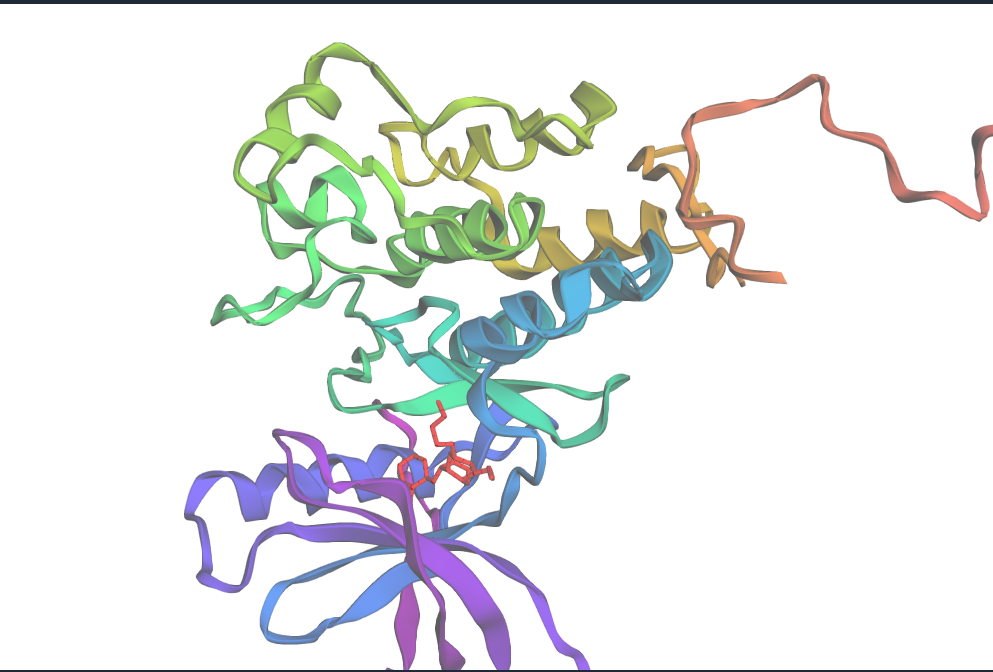